In [2]:
import pandas as pd

# -*- coding: utf-8 -*-
"""
@name: Week 3 Poisson GLM.py
@author: Ming-Long Lam, Ph.D.
@organization: University of Chicago
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sys
# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)
pandas.options.display.float_format = '{:,.10}'.format
import seaborn as sns
import math
from scipy.stats import chi2

sys.path.append('C:\\MScAnalytics\\Linear and Nonlinear Model\\Job')
import Regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [8]:
target = 'SEVERITY'
exposure = 'EXPOSURE'
cat_cols = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1","RED_CAR","REVOKED","URBANICITY"]
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY",'HOMEKIDS', 'KIDSDRIV', "AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF","TRAVTIME"]
claim_history = pd.read_excel('claim_history.xlsx')
claim_history[["BLUEBOOK", "HOME_VAL", "INCOME"]] = claim_history[["BLUEBOOK", "HOME_VAL", "INCOME"]] / 1000
claim_history[target] = np.where(claim_history['CLM_COUNT']>0,(claim_history['CLM_AMT']/claim_history['CLM_COUNT']),0)

In [12]:
train_data = claim_history[claim_history['EXPOSURE'] > 0.0]
train_data = train_data[[target] + [exposure] + int_pred]  # Only necessary
train_data = train_data.dropna().reset_index()  # Remove missing values
train_data.head()

,index,SEVERITY,EXPOSURE,CAR_TYPE,CAR_USE,EDUCATION,GENDER,MSTATUS,PARENT1,RED_CAR,REVOKED,URBANICITY,HOMEKIDS,KIDSDRIV,AGE,BLUEBOOK,CAR_AGE,HOME_VAL,INCOME,YOJ,MVR_PTS,TIF,TRAVTIME
0,1,0.0,1.0,Minivan,Commercial,High School,M,No,No,yes,No,Highly Urban/ Urban,0,0,43.0,14.94,1.0,257.0,91.0,11.0,0,1,22
1,3,0.0,0.828,SUV,Private,High School,F,Yes,No,no,No,Highly Urban/ Urban,1,0,35.0,4.01,10.0,124.0,16.0,10.0,3,4,5
2,14,0.0,1.0,Minivan,Private,Masters,F,Yes,No,no,No,Highly Rural/ Rural,0,0,43.0,22.42,1.0,210.0,53.0,5.0,0,7,36
3,15,0.0,1.0,Van,Commercial,Bachelors,M,Yes,No,yes,Yes,Highly Urban/ Urban,0,0,55.0,17.6,9.0,180.0,59.0,11.0,3,7,25
4,18,"2,920.0",1.0,SUV,Private,Below High Sc,F,Yes,No,no,No,Highly Urban/ Urban,0,0,45.0,6.0,5.0,107.0,0.0,0.0,3,1,48


Text(0.5, 0, 'Severity')

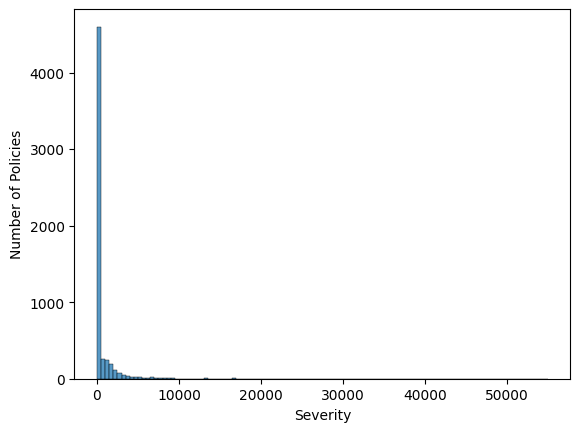

In [13]:
q1a = sns.histplot(train_data[target],binwidth=500)
q1a.set_ylabel("Number of Policies")
q1a.set_xlabel("Severity")

Text(0.5, 0, 'Severity')

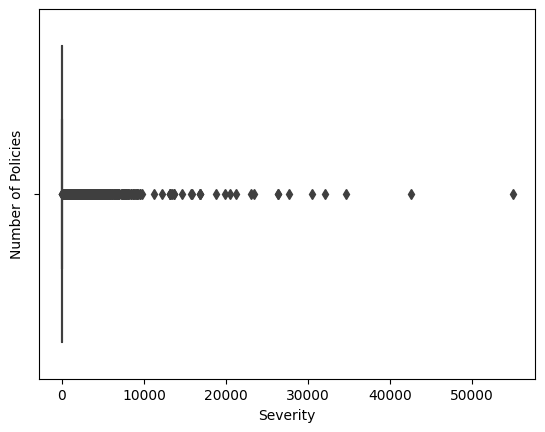

In [16]:
q1b = sns.boxplot(data=train_data,x = target, orient="h")
q1b.set_ylabel("Number of Policies")
q1b.set_xlabel("Severity")

In [40]:
n_sample = train_data.shape[0]
y_train = train_data[target]
o_train = train_data[exposure]
X0_train = train_data[[target]]
X0_train.insert(0, 'Intercept', 1.0)
X0_train = X0_train.drop(columns=target)
maxIter = 20
tolS = 1e-7
resultList = Regression.GammaRegression (X0_train, y_train, offset = o_train, maxIter = maxIter, tolSweep = tolS)
llk = resultList[3]
nonAliasParam = resultList[4]
outIterationTable = resultList[5]
y_pred = resultList[6]
aic = -2 * llk + 2 * len(nonAliasParam)
bic = -2 * llk + len(nonAliasParam) * math.log(n_sample)
print("###############################################################################################################")
# Question 1.2
print("Log Liklehood = " + str(llk), "AIC = " + str(aic), "BIC = " + str(bic))

###############################################################################################################
Log Liklehood = inf AIC = -inf BIC = -inf


c:\Users\yomaa\Documents\Github\University-of-Chicago\Environment\uchicago_venv\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yomaa\Documents\Github\University-of-Chicago\Environment\uchicago_venv\Lib\site-packages\Regression.py:562: RuntimeWarning: invalid value encountered in double_scalars
  if ((llk_next - llk) > - tolLLK):


In [24]:
def create_categorical_value(dfs, column_name):
    u = dfs[column_name].astype('category')
    u_freq = u.value_counts(ascending=True)
    pm = u.cat.reorder_categories(list(u_freq.index))
    term_df_type = pandas.get_dummies(pm)
    return term_df_type

In [34]:
def run_against_all(dfs, init_cols, categorical_cols, previous_train, output_train, ll, dv):
    step_detail = []
    output_list = []
    for i in init_cols:
        if i in categorical_cols:
            new_train = previous_train.join(create_categorical_value(dfs, i), rsuffix=i)
        else:
            new_train = previous_train.join(dfs[i], rsuffix=i)
        maxIter = 20
        tolS = 1e-7
        regression_output = Regression.GammaRegression(new_train, output_train, offset = None, maxIter = maxIter, tolSweep = tolS)
        ll_1 = regression_output[3]
        dv_1 = len(regression_output[4])
        dev_chisq = 2 * (ll_1 - ll)
        deviance_df = dv_1 - dv
        dev_sig = chi2.sf(dev_chisq, deviance_df)
        step_detail.append([str(i), dv_1, ll_1, dev_chisq, deviance_df, dev_sig])
        output_list.append(regression_output)
    step_df = pd.DataFrame(step_detail)
    chosen_value = step_df[step_df[5] == step_df[5].min()]
    chosen_output = output_list[step_df.index[step_df[5] == step_df[5].min()].tolist()[0]]
    return chosen_value.values, chosen_output

In [37]:
def forward_selector(data, target_col, init_cols, cat_columns):
    # First Run
    target_train = data[target_col]
    intercept_train = data[[target_col]]
    init = init_cols
    intercept_train.insert(0, 'Intercept', 1.0)
    intercept_train = intercept_train.drop(columns=target_col)
    maxIter = 20
    tolS = 1e-7
    intercept_result = Regression.GammaRegression(intercept_train, target_train, offset = None, maxIter = maxIter, tolSweep = tolS)
    step_summary = []
    ll = intercept_result[3]
    dv = len(intercept_result[4])
    dev_sig = 0
    threshold = 0.01
    value_outputs = None
    step_summary.append(['Intercept', dv, ll, np.nan, np.nan, np.nan])
    while dev_sig < threshold:
        run, s = run_against_all(data, init, cat_columns, intercept_train, target_train, ll, dv)
        run = run[0]
        ll = run[2]
        dv = run[1]
        dev_sig = run[5]
        if dev_sig < threshold:
            value_outputs = s
            if run[0] in cat_columns:
                intercept_train = intercept_train.join(create_categorical_value(data, run[0]), rsuffix=str(run[0]))
            else:
                intercept_train = intercept_train.join(data[run[0]], rsuffix=str(run[0]))
            init.remove(run[0])
            step_summary.append([run[0], dv, ll, run[3], run[4], run[5]])
    step_summary = pd.DataFrame(step_summary)
    return step_summary, value_outputs, intercept_result

In [36]:
int_pred = ["CAR_TYPE", "CAR_USE", "EDUCATION", "GENDER", "MSTATUS", "PARENT1", "RED_CAR", "REVOKED", "URBANICITY",
            'HOMEKIDS', 'KIDSDRIV', "AGE", "BLUEBOOK", "CAR_AGE", "HOME_VAL", "INCOME", "YOJ", "MVR_PTS", "TIF",
            "TRAVTIME"]
df, outps, train = forward_selector(train_data, target, int_pred, cat_cols)
print("###############################################################################################################")
# Question 2.1
print(df)

c:\Users\yomaa\Documents\Github\University-of-Chicago\Environment\uchicago_venv\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yomaa\Documents\Github\University-of-Chicago\Environment\uchicago_venv\Lib\site-packages\Regression.py:562: RuntimeWarning: invalid value encountered in double_scalars
  if ((llk_next - llk) > - tolLLK):
c:\Users\yomaa\Documents\Github\University-of-Chicago\Environment\uchicago_venv\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yomaa\Documents\Github\University-of-Chicago\Environment\uchicago_venv\Lib\site-packages\Regression.py:562: RuntimeWarning: invalid value encountered in double_scalars
  if ((llk_next - llk) > - tolLLK):
C:\Users\yomaa\AppData\Local\Temp\ipykernel_2492\1571718093.py:14: RuntimeWarning: invalid value encountered in 

IndexError: list index out of range

In [ ]:
print("###############################################################################################################")
# Question 2.2
print(outps[0])

In [ ]:
aic = -2 * outps[3] + 2 * len(outps[4])
bic = -2 * outps[3] + len(outps[4]) * math.log(n_sample)

print("###############################################################################################################")
# Question 2.3
print("AIC = " + str(aic), "BIC = " + str(bic))

In [29]:
def distance_corr(x, y):
    # Calculate the Adjusted Distance for x
    x_new = pd.DataFrame(x)
    y_new = pd.DataFrame(y)
    x_new = x_new.dropna()
    y_new = y_new.dropna()
    x_new = x_new.fillna(0)
    i = x_new.to_numpy().T[0]
    n = len(i)
    distance_matrix_x = pd.DataFrame(np.abs(i[:, None] - i))
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=0), axis=1)
    distance_matrix_x = distance_matrix_x.sub(distance_matrix_x.mean(axis=1), axis=0)
    emp_dist_x = distance_matrix_x.pow(2)
    emp_dist_x = emp_dist_x.values.sum() / (n ** 2)

    # Calculate the Adjusted Distance for y
    y_new = y_new.fillna(0)
    d = y_new.to_numpy().T[0]
    n = len(i)
    distance_matrix_y = pd.DataFrame(np.abs(d[:, None] - d))
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=0), axis=1)
    distance_matrix_y = distance_matrix_y.sub(distance_matrix_y.mean(axis=1), axis=0)
    emp_dist_y = distance_matrix_y.pow(2)
    emp_dist_y = emp_dist_y.values.sum() / (n ** 2)

    # Calculate the Distance covariance
    emp_dist_xy = distance_matrix_x.mul(distance_matrix_y, axis="index")
    emp_dist_xy = emp_dist_xy.values.sum() / (n ** 2)

    # Calculate the Distance Correlation Coefficient
    distance_correlation_coeff = math.sqrt(emp_dist_xy / (math.sqrt(emp_dist_x * emp_dist_y)))
    return distance_correlation_coeff


In [ ]:
def find_metrics(y_actual, y_predicted):
      y_simple_residual = y_train - y_pred
      mse = np.mean(np.power(y_simple_residual, 2))
      rmse = np.sqrt(mse)
      observed_mean = np.mean(y_actual)
      rel_error = mse / np.var(y_train, ddof = 0)
      dist_corr = distance_corr(y_actual, y_predicted)
      pearson_corr = np.power(np.corrcoef(y_actual, y_predicted), 2)
      ape = np.abs(y_simple_residual) / y_train
      mape = np.mean(ape)
      output_metric = pd.DataFrame({"RMSE": [round(rmse, 8)], "Relative Error": [round(rel_error, 8)],"Pearson Correlation": [round(pearson_corr.iloc[0][1], 8)],"Distance Correlation": [round(dist_corr, 8)], "Mean Absolute Proportion Error": [round(mape, 8)]})
      return output_metric

In [ ]:
y_train = train_data[target].values
y_pred = outps[6]

In [ ]:
print("###############################################################################################################")
# Question 3.1
print(find_metrics(y_train, resultList[6]))

In [ ]:
print("###############################################################################################################")
# Question 3.2
print(find_metrics(y_train, outps[6]))

In [ ]:
y_simple_residual = y_train - y_pred
pearson_residual = y_simple_residual / np.sqrt(y_pred)
pearson_chi_statistic = np.sum((y_train - y_pred) ** 2 / y_pred)
r_vec = y_train / y_pred
di_2 = 2 * (r_vec - np.log(r_vec) - 1)
devResid = np.where(y_simple_residual > 0, 1.0, -1.0) * np.sqrt(di_2)
dof = n_sample - len(outps[4])
deviance_chisq = np.sum(np.power(devResid, 2.0))
pearson_sig = chi2.sf(pearson_chi_statistic, dof)
deviance_sig = chi2.sf(deviance_chisq, dof)
comparative_output = pd.DataFrame(
    {"Type": ["Pearson", "Deviance"], "Statistic": [pearson_chi_statistic, deviance_chisq],
     "Degrees of Freedom": [dof, dof], "Significance": [pearson_sig, deviance_sig]})
print("###############################################################################################################")
# Question 3.3
print(comparative_output)

In [ ]:
# Question 4.1
plt.figure(dpi=200)
sg = plt.scatter(y_train, pearson_residual, c=train_data[exposure], marker='o', cmap="viridis")
plt.xlabel('Severity')
plt.ylabel('Pearson Residual')
plt.xticks(range(10))
plt.grid(axis='both')
plt.colorbar(sg, label='Exposure')
plt.grid()
plt.show()

In [ ]:
# Question 4.2
plt.figure(dpi=200)
sg = plt.scatter(y_train, devResid, c=train_data[exposure], marker='o', cmap="viridis")
plt.xlabel('Severity')
plt.ylabel('Deviance Residual')
plt.xticks(range(10))
plt.grid(axis='both')
plt.colorbar(sg, label='Exposure')
plt.grid()
plt.show()